In [231]:
import requests
import datetime
import pandas as pd
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [232]:
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

In [234]:
symbols = ['Bitfinex', 'Binance', 'Coinbase', 'Bitmex']

time_delta = 1 # Bar width in minutes

base = 'BTC'

df_bfx = hourly_price_historical(base, 'USD', 9999, time_delta, exchange = symbols[0])
df_bnc = hourly_price_historical(base, 'USDT', 9999, time_delta, exchange = symbols[1])
df_coi = hourly_price_historical(base, 'USD', 9999, time_delta, exchange = symbols[2])


x = df_bfx['close']
y = df_bnc['close']
z = df_coi['close']

time = df_bfx['timestamp']



Text(0,0.5,'BTC')

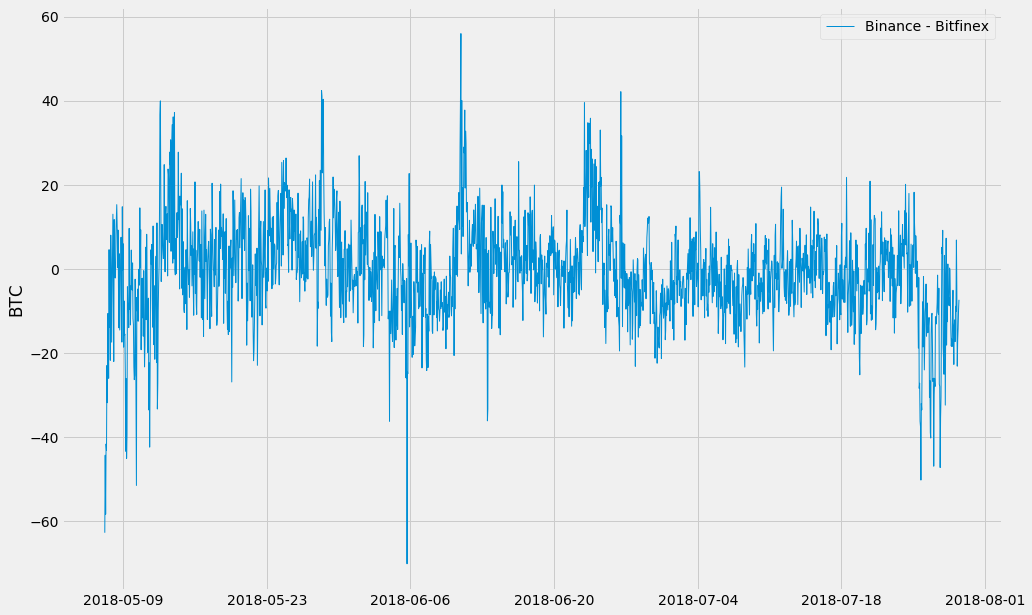

In [246]:
df1 = pd.DataFrame({'x': x, 'y': y,  'z': z, 'time': time})

df1['spread1'] = df1.y - 2*df1.x + df1.z
df1['spread2'] = df1.x - 2*df1.z + df1.y
df1['spread3'] = df1.z - 2*df1.y + df1.x


result1 = ts.adfuller(df1.spread1)
result2 = ts.adfuller(df1.spread2)
result3 = ts.adfuller(df1.spread3)

start = 1
end = 2000

range = (start,end)


fig2 = plt.figure(figsize=(15,10))
ax1 = fig2.add_subplot(111)
ax1.plot(time[start:end], df1.spread1[start:end], linewidth=1.0)
#ax1.plot(time[start:end], df1.spread2[start:end], color = 'r',linewidth=1.0)
#ax1.plot(time[start:end], df1.spread3[start:end], color = 'g', linewidth=1.0)
plt.legend(['Binance - Bitfinex','Bitfinex - Coinbase ', 'Coinbase - Binance'])
ax1.set_ylabel(base)



In [228]:
#calculate Hurst Exponent

def hurst(ts):
    lags = range(2,100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0] * 2.0

#hurst =  round(hurst(df1.spread1),2)

# claculate Halflife

spread_lag = df1.spread3.shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]
spread_ret = df1.spread3 - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]
spread_lag2 = sm.add_constant(spread_lag)
model = sm.OLS(spread_ret, spread_lag2)
res = model.fit()

halflife = -np.log(2) / res.params[1], 

In [229]:
halflife

(2.150198039572156,)

In [230]:
df1

,time,x,y,z,spread1,spread2,spread3
0,2018-05-06 07:00:00,180.24,180.46,178.14,0.22,2.10,-2.32
1,2018-05-06 08:00:00,174.71,174.50,173.76,-0.21,0.95,-0.74
2,2018-05-06 09:00:00,173.12,173.18,172.84,0.06,0.28,-0.34
3,2018-05-06 10:00:00,174.17,174.37,173.49,0.20,0.68,-0.88
4,2018-05-06 11:00:00,171.17,171.32,169.50,0.15,1.67,-1.82
5,2018-05-06 12:00:00,170.88,170.89,169.21,0.01,1.67,-1.68
6,2018-05-06 13:00:00,171.05,171.03,169.60,-0.02,1.45,-1.43
7,2018-05-06 14:00:00,169.08,168.80,167.94,-0.28,1.14,-0.86
8,2018-05-06 15:00:00,168.60,168.15,167.56,-0.45,1.04,-0.59
9,2018-05-06 16:00:00,170.19,169.89,169.89,-0.30,0.30,0.00


Max length = 2001
Max time = 1 days 09:20:00


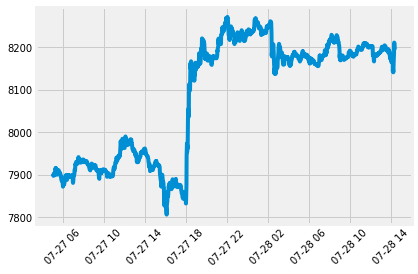

In [92]:
time_delta = 1 # Bar width in minutes
df = minute_price_historical('BTC', 'USD', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,7901.68,7901.76,7900.26,7900.26,1532656860,31.65,252064.18,2018-07-27 05:01:00
1,7899.03,7901.72,7897.51,7901.68,1532656920,25.45,202303.73,2018-07-27 05:02:00
2,7897.96,7898.82,7897.47,7898.42,1532656980,10.58,83527.47,2018-07-27 05:03:00
3,7900.28,7900.50,7897.83,7897.96,1532657040,33.60,265245.43,2018-07-27 05:04:00
4,7902.54,7902.57,7900.27,7900.28,1532657100,23.49,185979.84,2018-07-27 05:05:00
5,7902.99,7903.04,7900.49,7902.54,1532657160,55.92,443031.04,2018-07-27 05:06:00
6,7901.82,7903.15,7901.82,7903.10,1532657220,21.69,172164.83,2018-07-27 05:07:00
7,7900.77,7901.82,7899.83,7901.82,1532657280,21.81,172402.85,2018-07-27 05:08:00
8,7899.13,7900.77,7898.10,7900.77,1532657340,17.77,140433.13,2018-07-27 05:09:00
9,7899.69,7899.69,7898.70,7899.13,1532657400,36.56,288992.22,2018-07-27 05:10:00
